In [21]:
# data ingestion
import pandas as pd

## Berlin
covid_bln = pd.read_csv(r'C:\Users\flori\Documents\covid_bln\covid_bln.csv', sep=';')

## boroughs
covid_bor = pd.read_csv(r'C:\Users\flori\Documents\covid_bln\covid_bor.csv', sep=';')

## age groups
covid_age = pd.read_csv(r'C:\Users\flori\Documents\covid_bln\covid_age.csv', sep=';')

In [22]:
# import libraries
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as  mdates
from matplotlib.dates import MonthLocator
import seaborn as sns

In [23]:
# data preparation
## Berlin
covid_bln = covid_bln.drop('id', 1)
covid_bln['datum'] = pd.to_datetime(covid_bln['datum'])
covid_bln = covid_bln.set_index('datum').sort_index(ascending=True)
covid_bln['7_tage_mittel'] = covid_bln['neue_faelle'].rolling(7).mean()
covid_bln = covid_bln['2020-03-01':'2021-04-04']

In [24]:
# data preparation
## boroughs
covid_bor = covid_bor.drop('id', 1).rename(**boroughs)
covid_bor['datum'] = pd.to_datetime(covid_bor['datum'])
covid_bor = covid_bor.set_index('datum').sort_index(ascending=True)
covid_bor = covid_bor['2020-03-01':'2021-04-04']

pop_bor = pd.read_csv(r'C:\Users\flori\Documents\covid_bln\pop_boroughs.csv', sep=';')
pop_bor = pop_bor.drop('jahr', 1).rename(**boroughs)
pop_bor_100k = pop_bor.div(100000).to_dict(orient='list')

for bor in covid_bor.columns:
    covid_bor[bor] = covid_bor[bor].rolling(7).sum()

covid_bor = covid_bor.div(pop_bor_100k, 1).round(decimals=1)

In [25]:
# data preparation
## age groups
covid_age_2020 = covid_age.drop(covid_age.loc[covid_age['jahr']==2021].index)
covid_age_2021 = covid_age.drop(covid_age.loc[covid_age['jahr']==2020].index)

covid_age_2020['datum_str'] = (covid_age_2020['jahr'].map(str) + ' ' + \
                         (covid_age_2020['meldewoche']-1).map(str) + ' 0').map(str)
    
covid_age_2020['datum'] = [dt.datetime.strptime(i, '%Y %W %w') \
                           for i in covid_age_2020['datum_str']]

covid_age_2021['datum_str'] = (covid_age_2021['jahr'].map(str) + ' ' + \
                               (covid_age_2021['meldewoche']).map(str) + ' 0').map(str)
    
covid_age_2021['datum'] = [dt.datetime.strptime(i, '%Y %W %w') \
                           for i in covid_age_2021['datum_str']]

covid_age_dates=covid_age_2020.append(covid_age_2021)

covid_age_piv=covid_age_dates.pivot_table(values='faelle', index='datum', 
                                    columns='altersgruppe')
covid_age_piv.index = covid_age_piv.index.strftime('%m/%d/%y')

covid_age_piv.columns = covid_age_piv.columns.str.replace(' ', '')

covid_age_piv['0-9'] = covid_age_piv['0-4'] + covid_age_piv['5-9']
covid_age_piv['10-19'] = covid_age_piv['10-14'] + covid_age_piv['15-19']
covid_age_piv['20-29'] = covid_age_piv['20-24'] + covid_age_piv['25-29']
covid_age_piv['80+'] = covid_age_piv['80-89'] + covid_age_piv['90+']

covid_age_piv = covid_age_piv.reindex(columns=['0-9', '10-19', '20-29', 
                                               '30-39', '40-49', '50-59', 
                                               '60-69', '70-79', '80+'])

covid_age_piv['gesamt'] = covid_age_piv.sum(1)

for age in covid_age_piv.columns:
    covid_age_piv[age] = covid_age_piv[age]/covid_age_piv['gesamt']*100

covid_age_piv = covid_age_piv.drop('gesamt', 1)

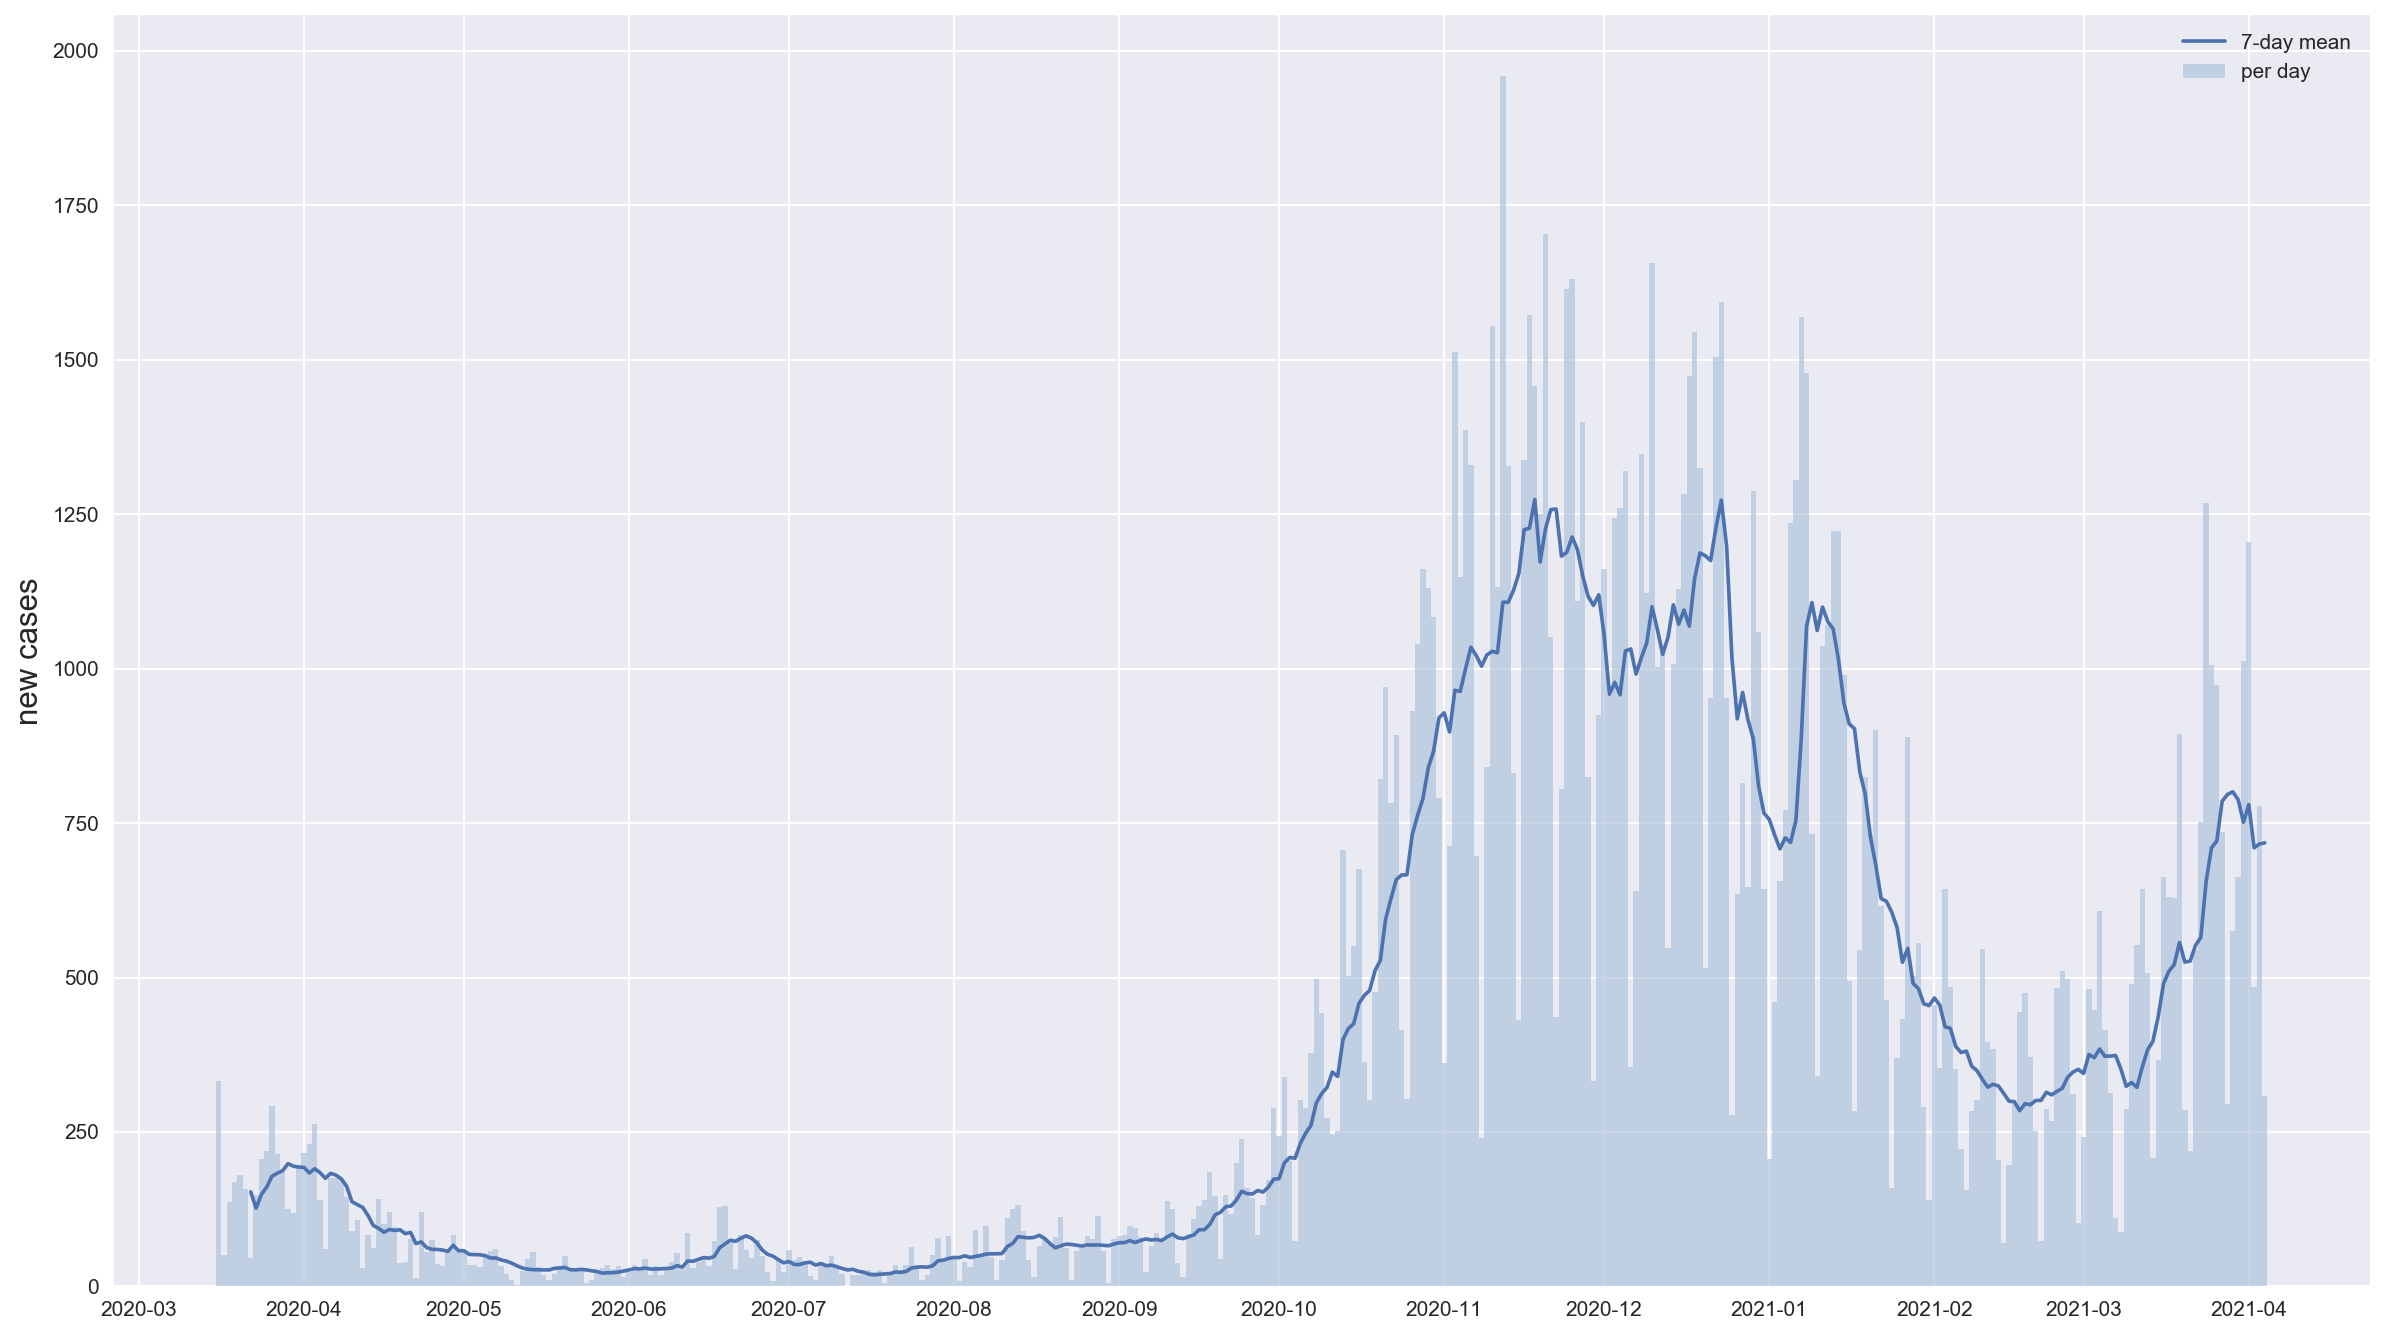

In [46]:
# cases March 2020 to April 2021 in Berlin
fig, ax = plt.subplots(figsize=(16,9), dpi=300)

ax.bar(covid_bln.index, covid_bln['neue_faelle'], 
       color='lightsteelblue', label="per day", alpha=0.7, width=1)
ax.set_ylabel("new cases", fontsize=15)

ax.plot(covid_bln.index, covid_bln['7_tage_mittel'], 
        label='7-day mean')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(MonthLocator())

ax.set_title("", fontsize=15)
ax.set_ylabel("new cases", fontsize=15)

ax.legend()

plt.style.use('seaborn')
plt.tight_layout()
plt.show()

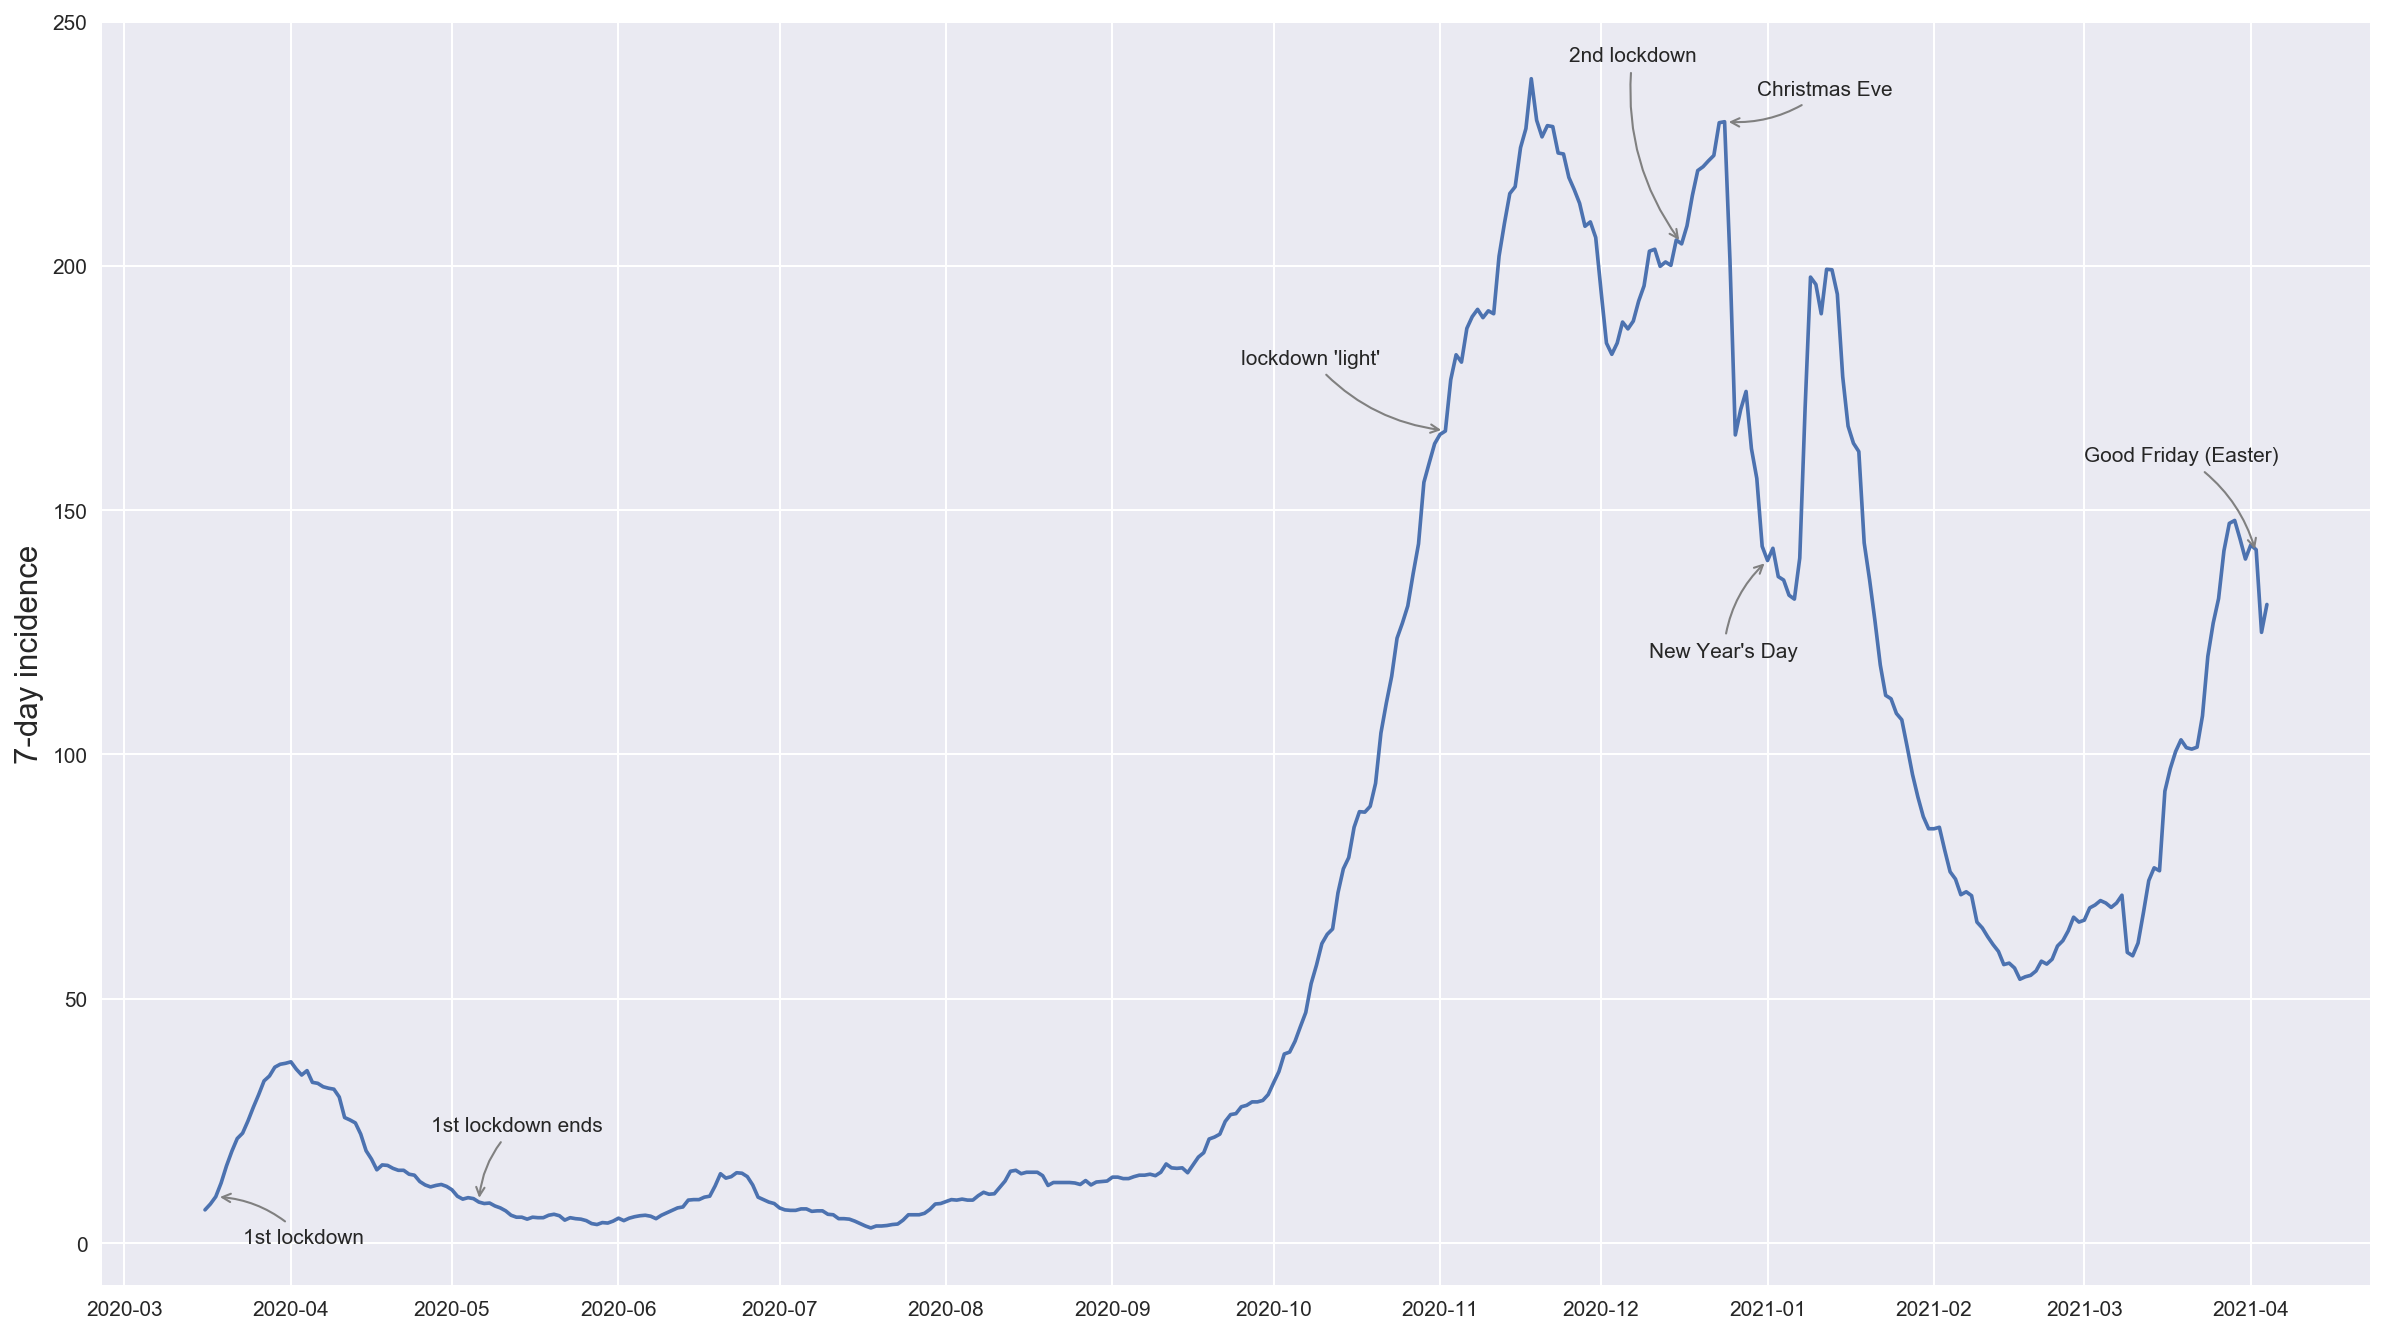

In [45]:
# 7-day incidence March 2020 to April 2021
## Berlin
fig, ax = plt.subplots(figsize=(16,9), dpi=300)

ax.plot(covid_bln.index, covid_bln['7_tage_inzidenz'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(MonthLocator())

ax.set_title("", fontsize=15)
ax.set_ylabel("7-day incidence", fontsize=15)

arrow=dict(
    arrowprops=dict(
        arrowstyle='->', 
        color='grey', 
        lw=1, 
        connectionstyle='arc3,rad=0.2'
        )
    )
 
arrow_rev=dict(
    arrowprops=dict(
        arrowstyle='->', 
        color='grey', 
        lw=1, 
        connectionstyle='arc3,rad=-0.2'
        )
    )

ax.annotate("1st lockdown", xy=(dt.date(2020,3,18), 9.5),
            xytext=(dt.date(2020,3,23), 0), **arrow)

ax.annotate("1st lockdown ends", xy=(dt.date(2020,5,6), 8.4), 
            xytext=(dt.date(2020,4,27), 23), **arrow)

ax.annotate("lockdown 'light'", xy=(dt.date(2020,11,2), 166.3), 
            xytext=(dt.date(2020,9,25), 180), **arrow)

ax.annotate("2nd lockdown", xy=(dt.date(2020,12,16), 204.6), 
            xytext=(dt.date(2020,11,25), 242), **arrow)

ax.annotate("Christmas Eve", xy=(dt.date(2020,12,24), 229.5), 
            xytext=(dt.date(2020,12,30), 235), **arrow_rev)

ax.annotate("New Year's Day", xy=(dt.date(2021,1,1), 139.7), 
            xytext=(dt.date(2020,12,10), 120), **arrow_rev)

ax.annotate("Good Friday (Easter)", xy=(dt.date(2021,4,2), 141.2), 
            xytext=(dt.date(2021,3,1), 160), **arrow_rev)

plt.style.use('seaborn')
plt.tight_layout()
plt.show()

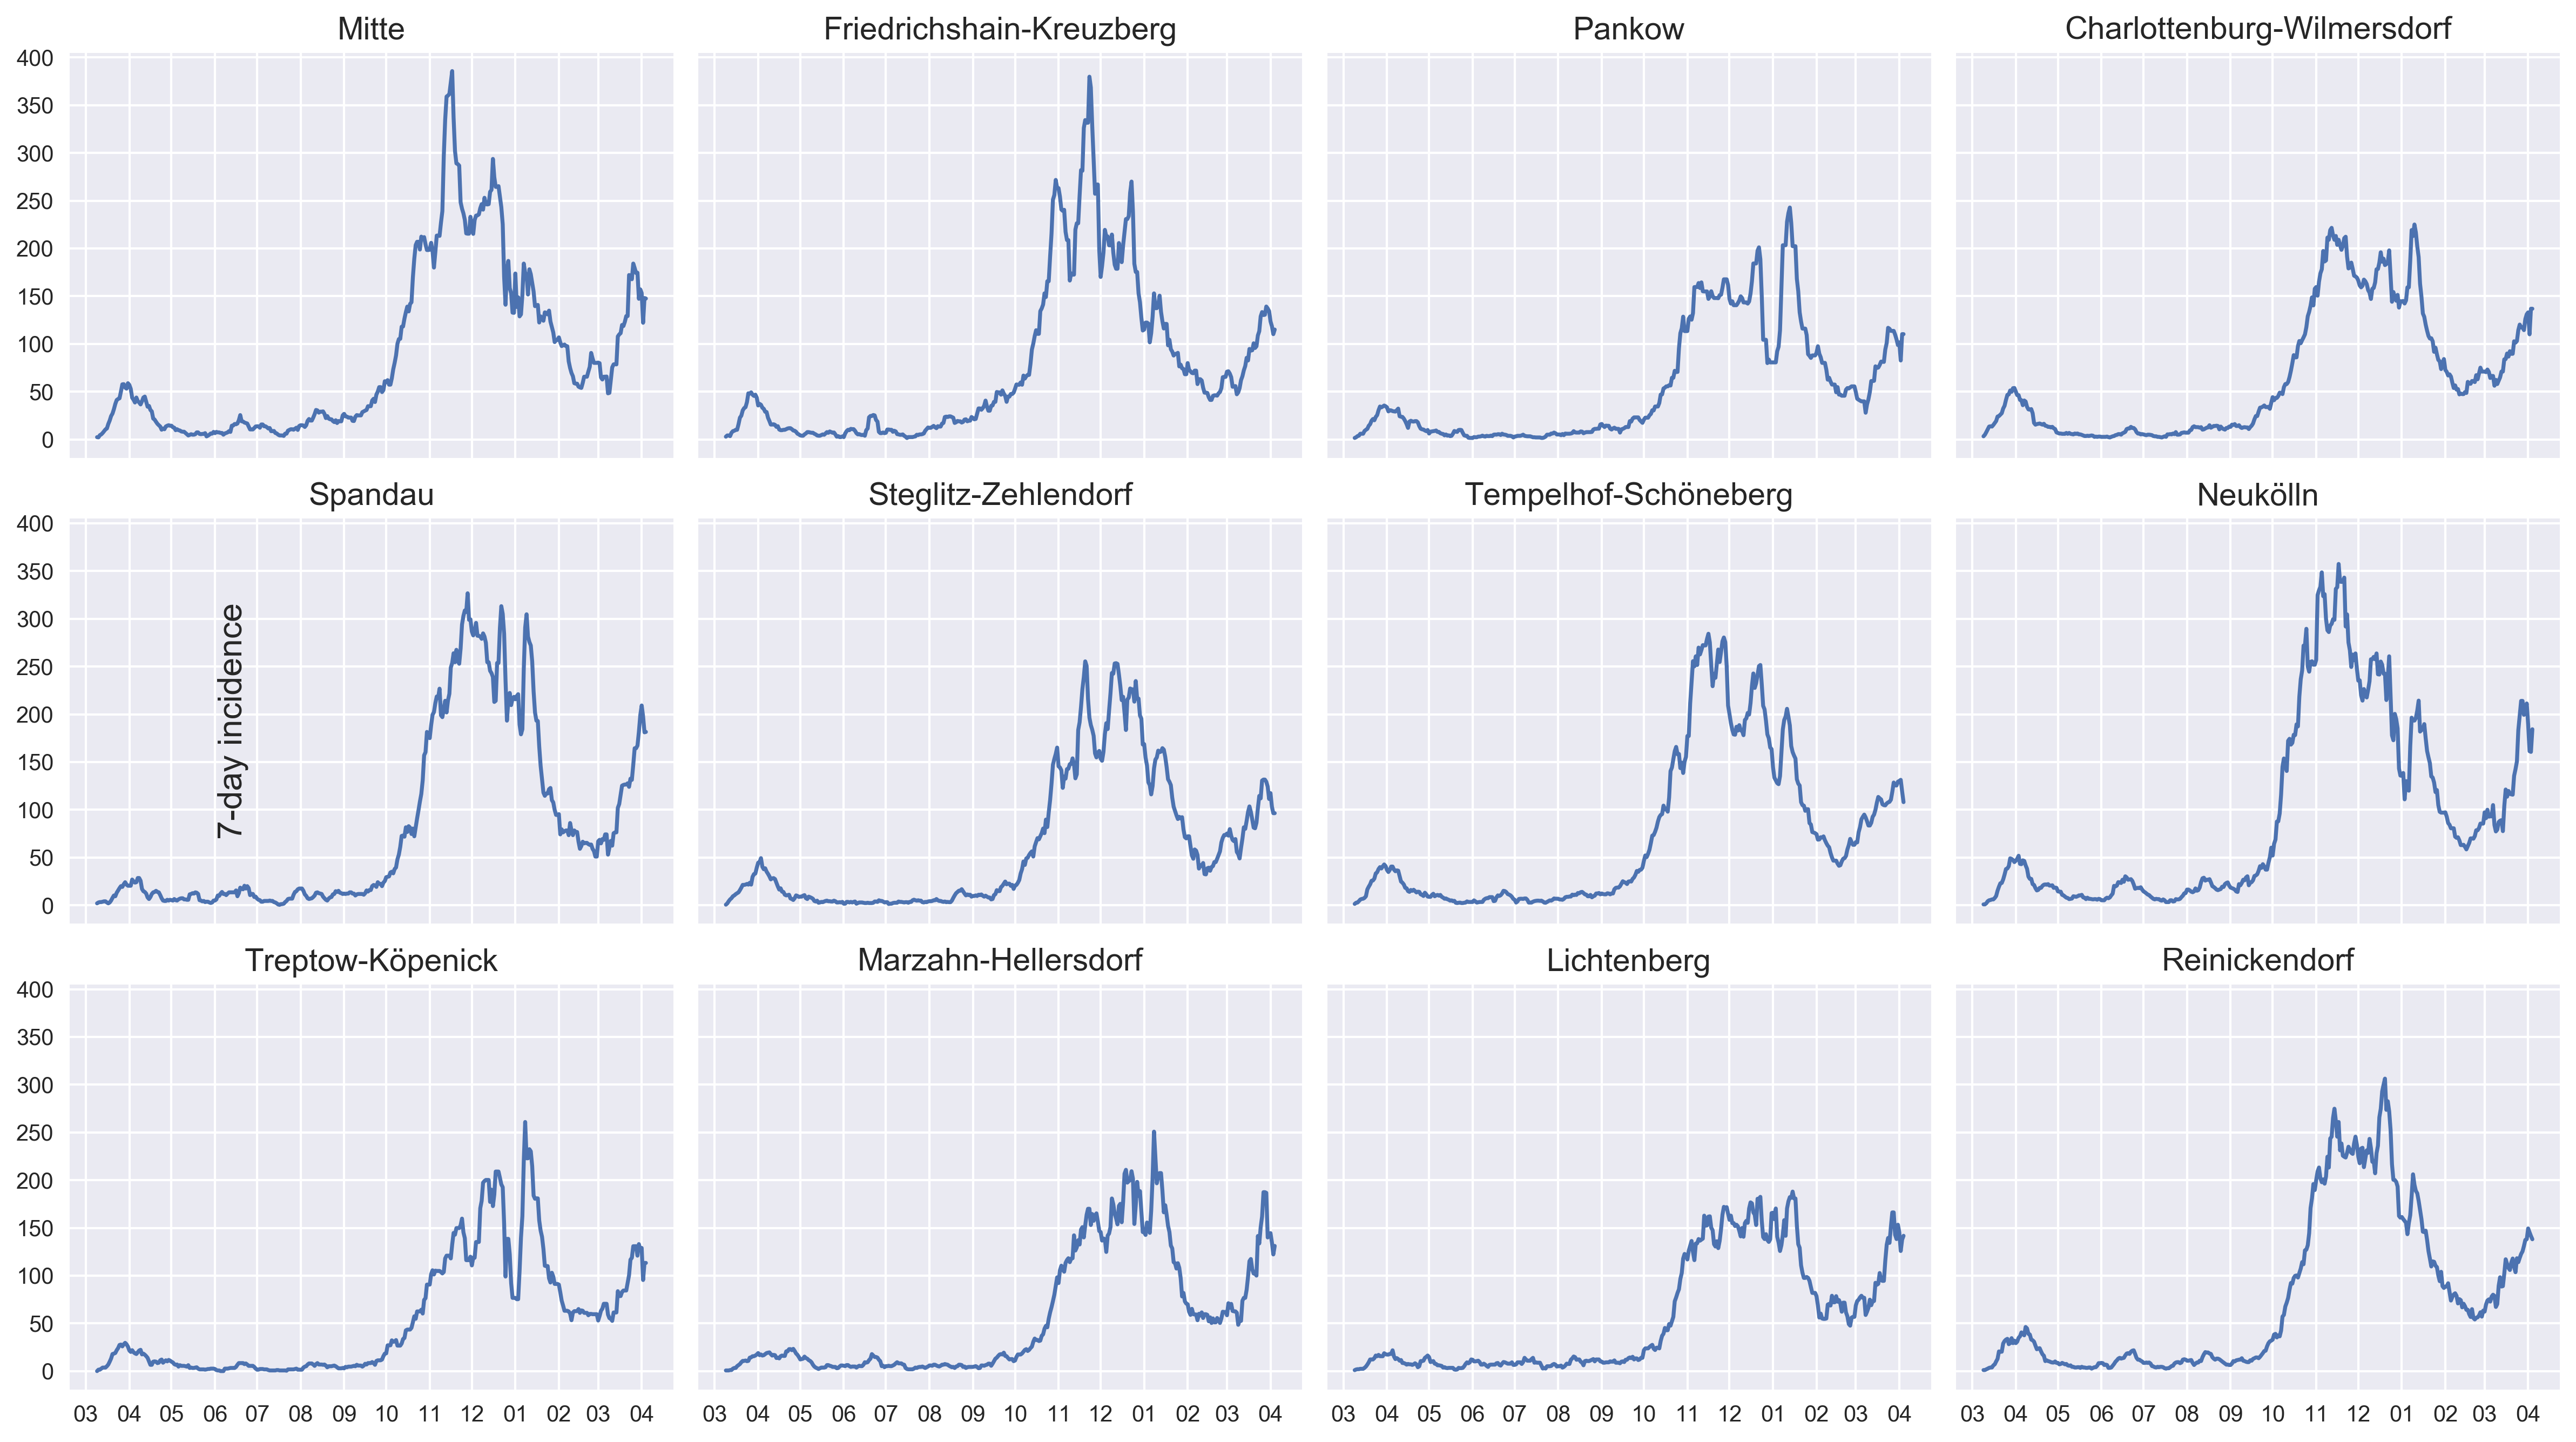

In [55]:
# 7-day incidence March 2020 to April 2021
## boroughs
bor_title = ["Mitte", "Friedrichshain-Kreuzberg", "Pankow",
             "Charlottenburg-Wilmersdorf", "Spandau", "Steglitz-Zehlendorf",
             "Tempelhof-Schöneberg", "Neukölln", "Treptow-Köpenick",
             "Marzahn-Hellersdorf", "Lichtenberg", "Reinickendorf"]

fig, axes = plt.subplots(3, 4, figsize=(16,9), sharey=True, sharex=True, dpi=300)

for i, ax in enumerate(axes.flatten()):
    ax.plot(covid_bor.iloc[:,0+i])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    ax.xaxis.set_major_locator(MonthLocator())
    ax.set_title(bor_title[0+i], fontsize=14)
    ax.tick_params('x', labelrotation=0)

fig.text(0.087, 0.5, "7-day incidence", va='center', 
         rotation='vertical', fontsize=15)
plt.style.use('seaborn')
plt.tight_layout()
plt.show()

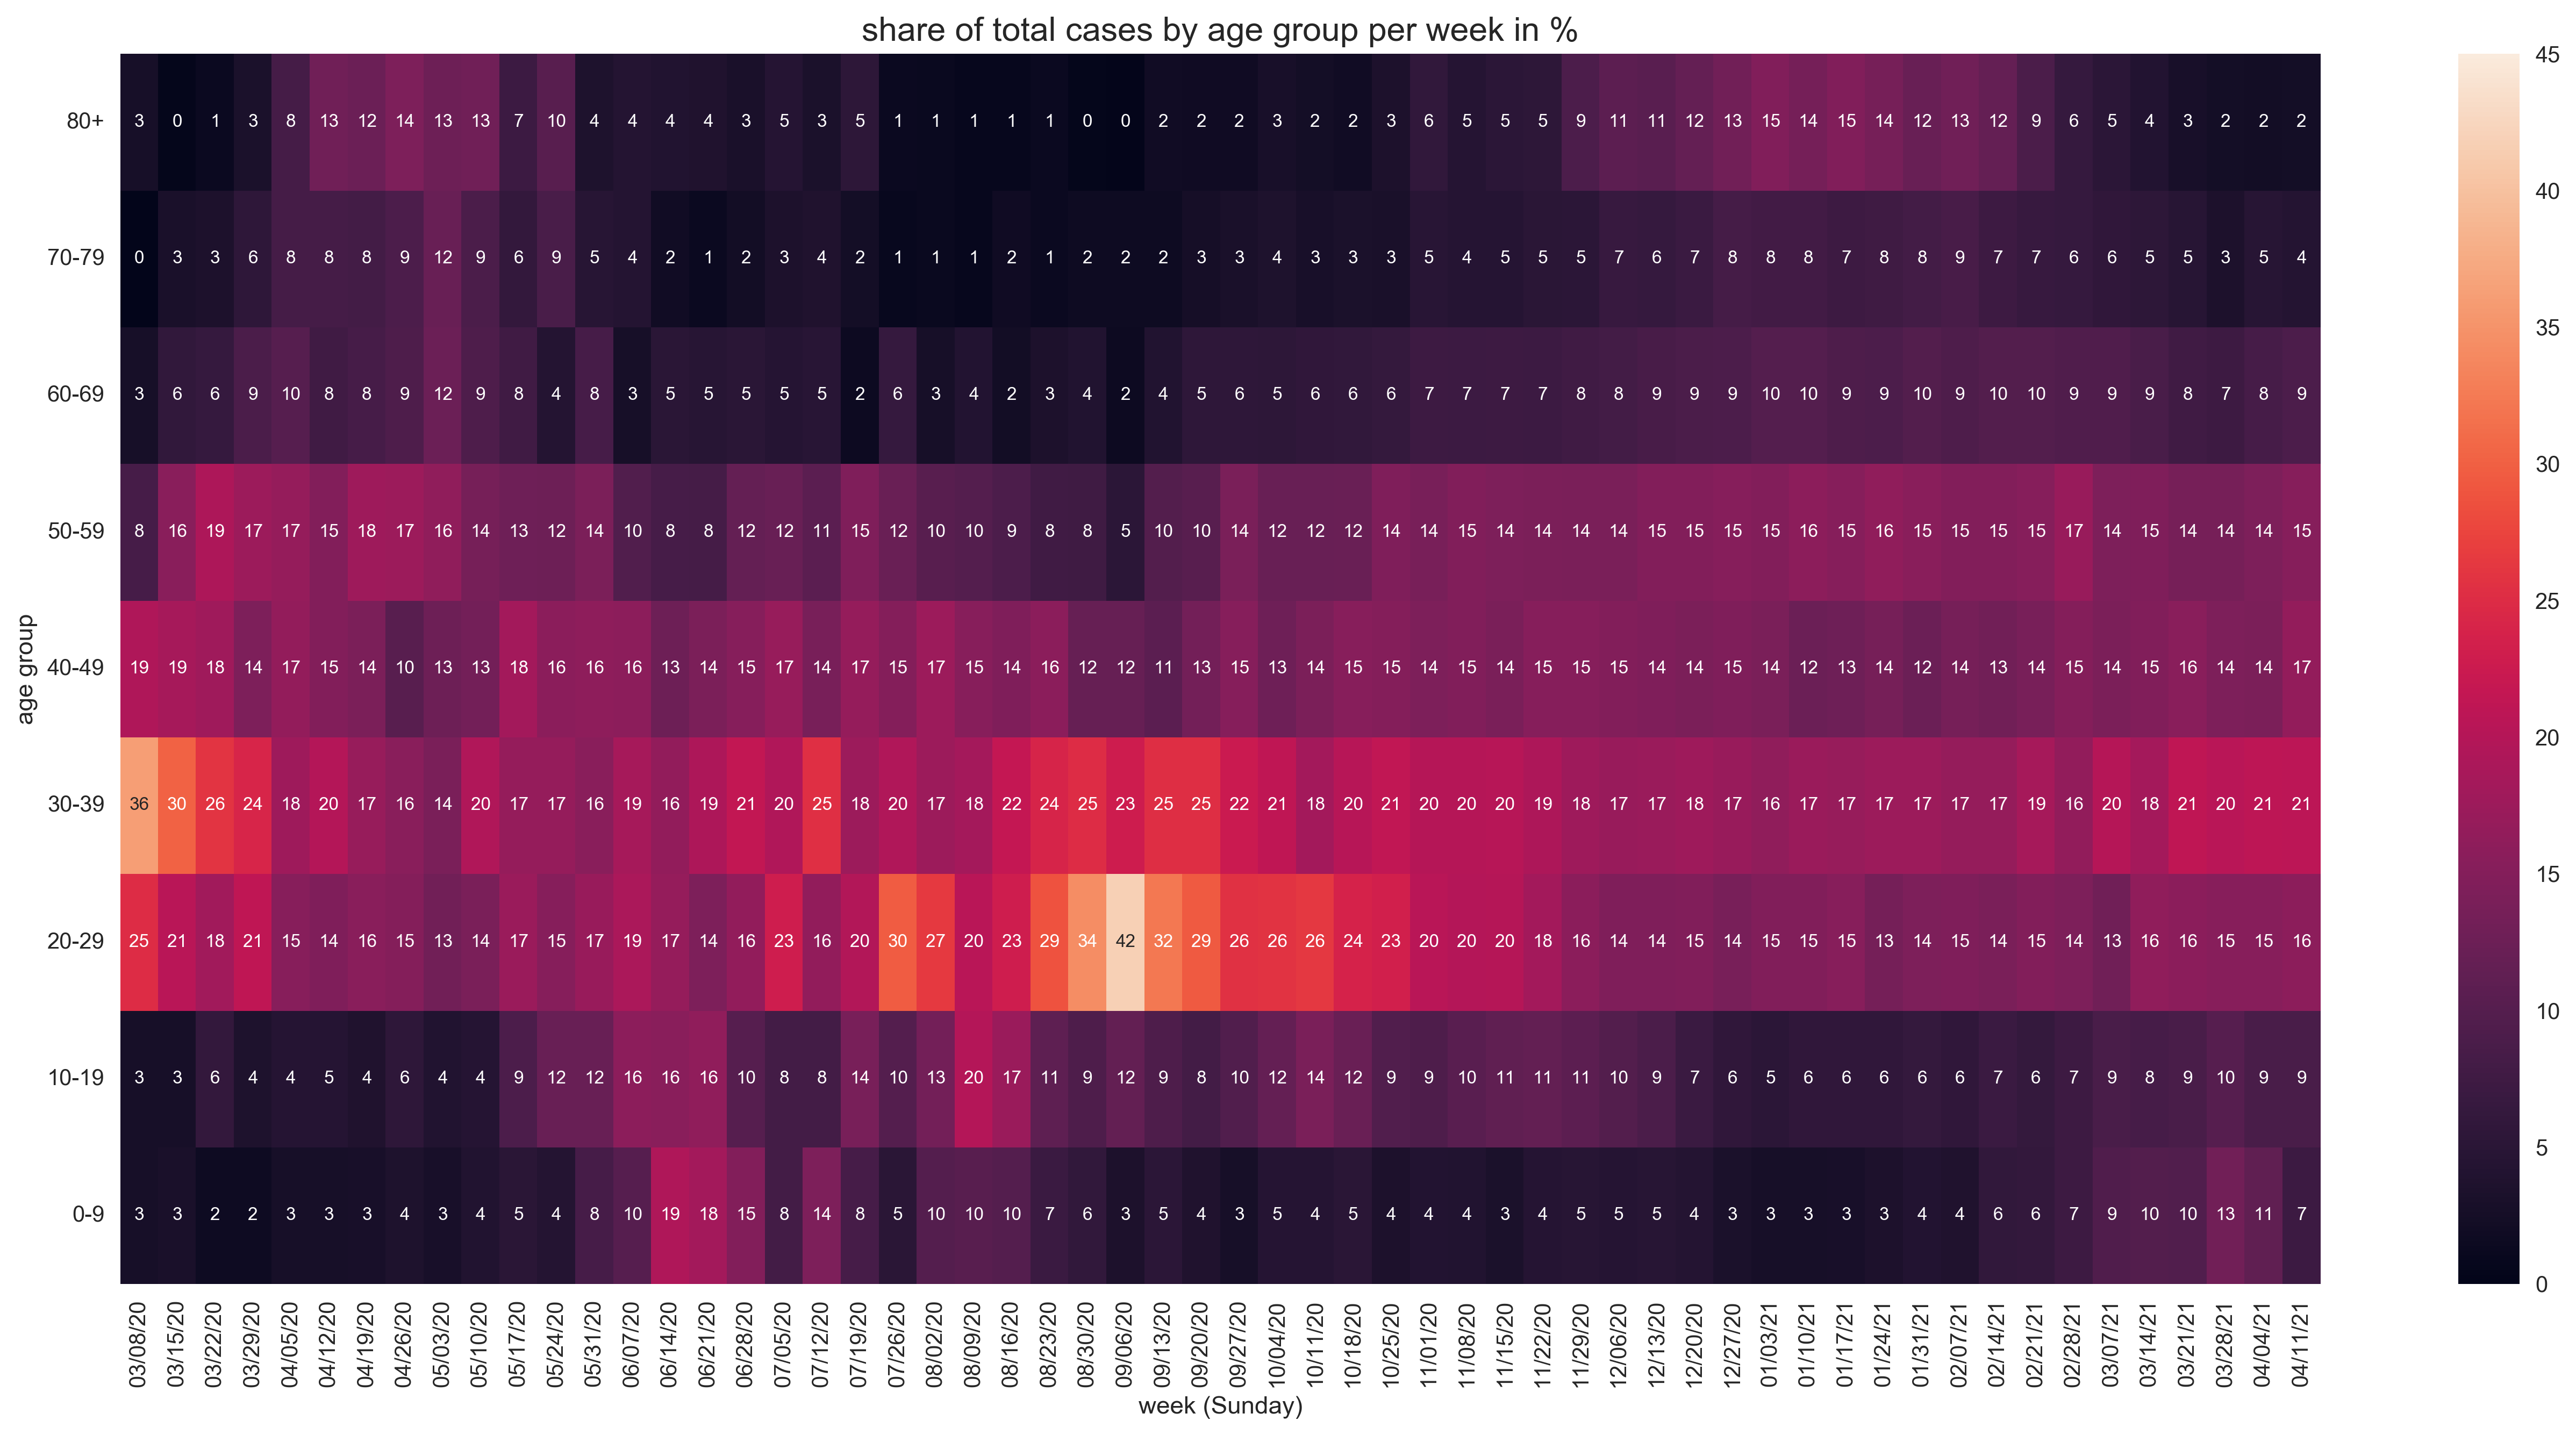

In [60]:
# cases by age group March 2020 to April 2021
fig, ax = plt.subplots(figsize=(18, 9), dpi=300)

sns.heatmap(covid_age_piv.transpose(), annot=True, cmap='rocket', vmax=45, 
            fmt='.0f', annot_kws=dict(size=8, rotation=0))

ax.set_title("share of total cases by age group per week in %", fontsize=15)
ax.set_xticklabels(covid_age_piv.index, rotation=90)
ax.set_yticklabels(labels=ax.get_yticklabels(), va='center', rotation=0)
ax.set_xlabel("week (Sunday)")
ax.set_ylabel("age group")

plt.style.use('seaborn')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()